# Sample Lya posterior as a function of nuisance parameters

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import cProfile
import emcee
import corner
# our own modules
import simplest_emulator
import linear_emulator
import gp_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import pressure_model
import lya_theory
import likelihood
import emcee_sampler

### Setup Lya likelihood function

In [2]:
# read P1D measurement
data=data_PD2013.P1D_PD2013(blind_data=True)
zs=data.z

In [3]:
basedir='../../p1d_emulator/sim_suites/emulator_512_17052019/'
p1d_label='p1d'
skewers_label='Ns100_wM0.05'
undersample_z=2
use_gp=True
if use_gp:
    emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,undersample_z=undersample_z,verbose=True,paramList=None,kmax_Mpc=5,train=True)
else:
    emu=linear_emulator.LinearEmulator(basedir,p1d_label,skewers_label,undersample_z=undersample_z,verbose=False)

latin hyper-cube data {'param_space': {'Om_star': {'ip': 0, 'min_val': 0.955, 'max_val': 0.975, 'z_star': 3.0, 'latex': '$\\Omega_\\star$'}, 'Delta2_star': {'ip': 1, 'min_val': 0.25, 'max_val': 0.45, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\Delta^2_\\star$'}, 'n_star': {'ip': 2, 'min_val': -2.35, 'max_val': -2.25, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$n_\\star$'}, 'alpha_star': {'ip': 3, 'min_val': -0.265, 'max_val': -0.165, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\alpha_\\star$'}, 'mu_He': {'ip': 4, 'min_val': 0.5, 'max_val': 2.0, 'latex': '$\\mu_{\\rm He}$'}, 'mu_H': {'ip': 5, 'min_val': 0.5, 'max_val': 2.0, '   latex': '$\\mu_{\\rm H}$'}}, 'nsamples': 10, 'samples': {'0': [0.972, 0.42000000000000004, -2.315, -0.19, 0.7250000000000001, 1.3250000000000002], '1': [0.96, 0.28, -2.295, -0.2, 1.3250000000000002, 1.475], '2': [0.966, 0.3, -2.305, -0.26, 1.025, 0.875], '3': [0.956, 0.4, -2.275, -0.25, 0.575, 1.175], '4': [0.968, 0.44, -2.325, -0.22, 1.475, 0.7250000000000001], '5': [

In [4]:
# specify free parameters in likelihood
#free_parameters=['ln_kF_0']
free_parameters=['ln_tau_0','ln_tau_1']
#free_parameters=['ln_tau_0','ln_tau_1','ln_T0_0','ln_gamma_0']
#free_parameters=['ln_tau_0','ln_tau_1','ln_T0_0','ln_T0_1','ln_gamma_0','ln_gamma_1']

In [5]:
sampler = emcee_sampler.EmceeSampler(emulator=emu,free_parameters=free_parameters,verbose=True)

use default likelihood
Note: redshifts have been re-sorted (earliest first)
setup with 20 walkers
set 20 walkers with 2 dimensions
done setting up sampler


In [6]:
for p in sampler.like.free_params:
    print(p.name,p.value,p.min_value,p.max_value)

ln_tau_0 -1.01609692034 -1.2 -0.4
ln_tau_1 4.21707371752 3.0 5.0


### Run burn-in chains

In [7]:
sampler.like.go_silent()

In [8]:
sampler.run_burn_in(nsteps=50)

start burn-in, will do 50 steps
0 [ 0.48190625  0.59900421]
20 [ 0.59345581  0.59893441]
40 [ 0.60988956  0.59058285]
finished burn-in


### Run main chains

In [9]:
sampler.run_chains(nsteps=200)

0 [ 0.48053513  0.560758  ]
20 [ 0.57865463  0.58451941]
40 [ 0.6092141   0.59825255]
60 [ 0.61105993  0.59484033]
80 [ 0.61173587  0.59497324]
100 [ 0.61269943  0.59360247]
120 [ 0.61132125  0.59247626]
140 [ 0.61107252  0.59489265]
160 [ 0.61333412  0.60052285]
180 [ 0.6126043   0.59513131]


In [10]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.sampler.acceptance_fraction)))

Mean acceptance fraction: 0.663


### Plot results in cube units (0 < x < 1)

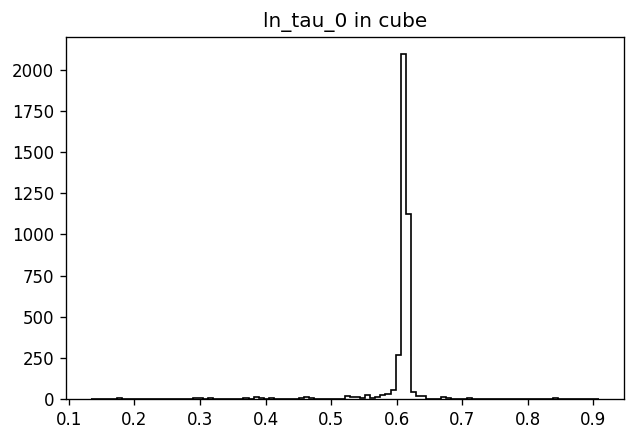

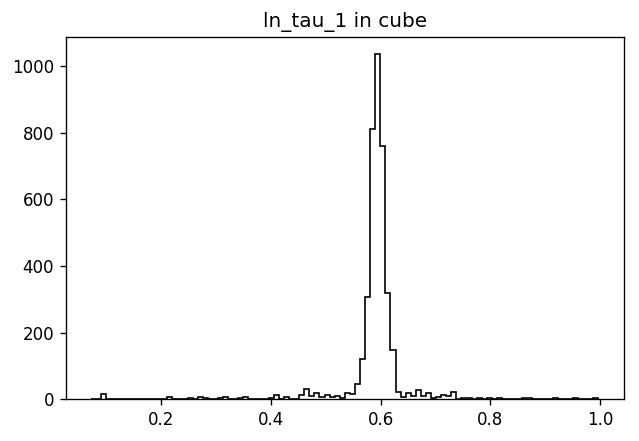

In [11]:
sampler.plot_histograms(cube=True)

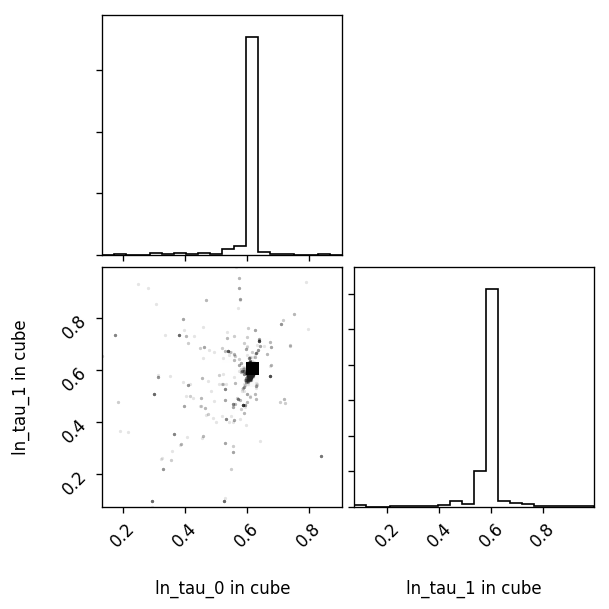

In [12]:
sampler.plot_corner(cube=True)

### Plot results for dimensional parameters

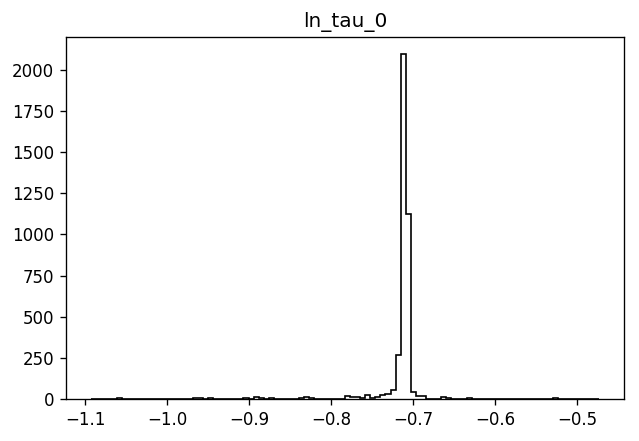

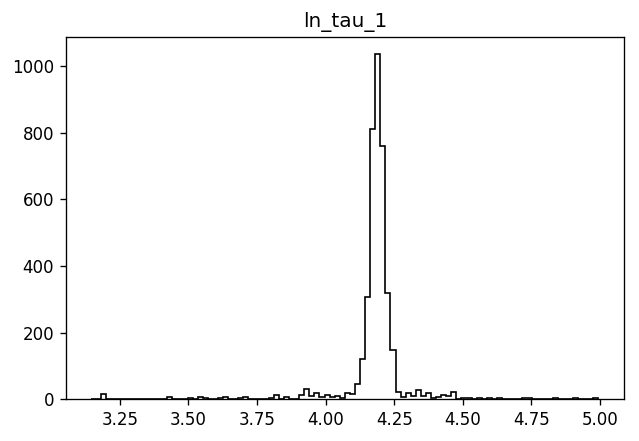

In [13]:
sampler.plot_histograms(cube=False)

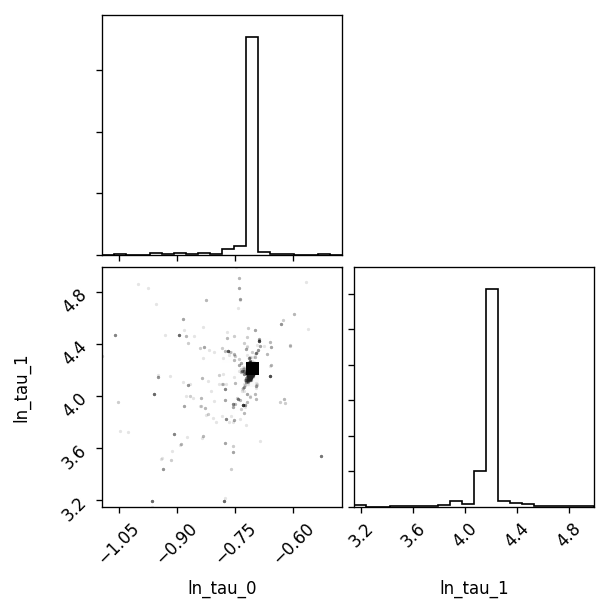

In [14]:
sampler.plot_corner(cube=False)

### Use likelihood object to make other useful plots

In [15]:
# get mean of chain
mcmc_mean=np.mean(sampler.sampler.flatchain,axis=0)
print('mean point',mcmc_mean)

mean point [ 0.60318604  0.59072789]


In [16]:
sampler.like.update_parameters(mcmc_mean)
for p in sampler.like.free_params:
    print(p.name,p.value)

ln_tau_0 -0.71745116988
ln_tau_1 4.18145577143


Text(0, 0.5, '<F>')

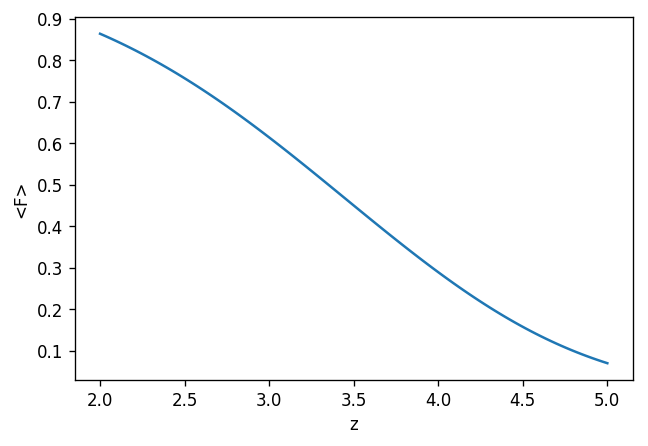

In [17]:
z=np.linspace(2.0,5.0,100)
mf=sampler.like.theory.mf_model.get_mean_flux(z)
plt.plot(z,mf)
plt.xlabel('z')
plt.ylabel('<F>')

Text(0, 0.5, '$T_0(z)$ [K]')

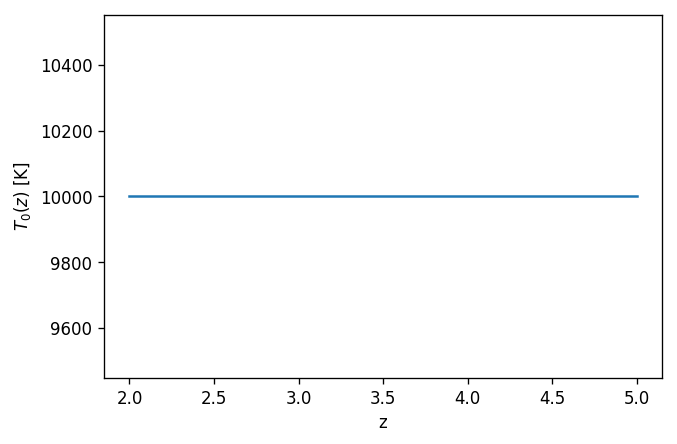

In [18]:
T0=sampler.like.theory.T_model.get_T0(z)
plt.plot(z,T0)
plt.xlabel('z')
plt.ylabel(r'$T_0(z)$ [K]')

Text(0, 0.5, '$\\sigma_T(z)$ [km/s]')

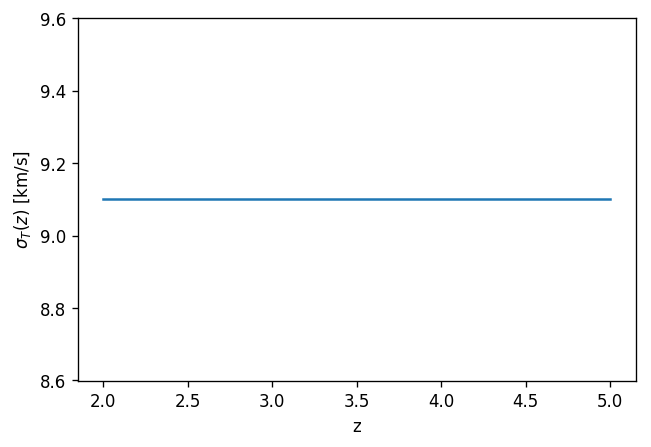

In [19]:
sigT=sampler.like.theory.T_model.get_sigT_kms(T0)
plt.plot(z,sigT)
plt.xlabel('z')
plt.ylabel(r'$\sigma_T(z)$ [km/s]')

Text(0, 0.5, '$k_F$ [s/km]')

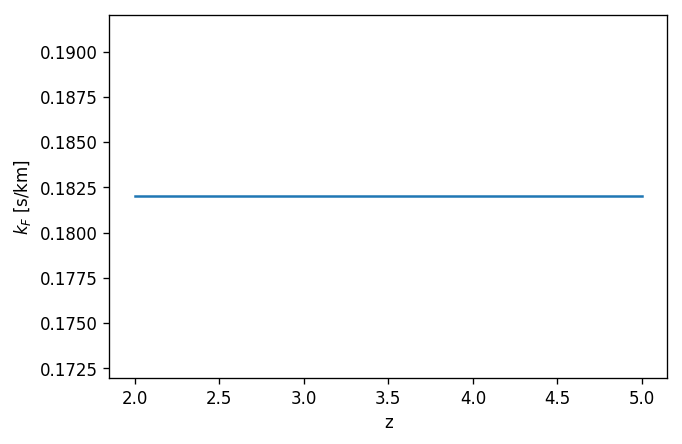

In [20]:
kF_kms=sampler.like.theory.kF_model.get_kF_kms(z)
plt.plot(z,kF_kms)
plt.xlabel('z')
plt.ylabel(r'$k_F$ [s/km]')

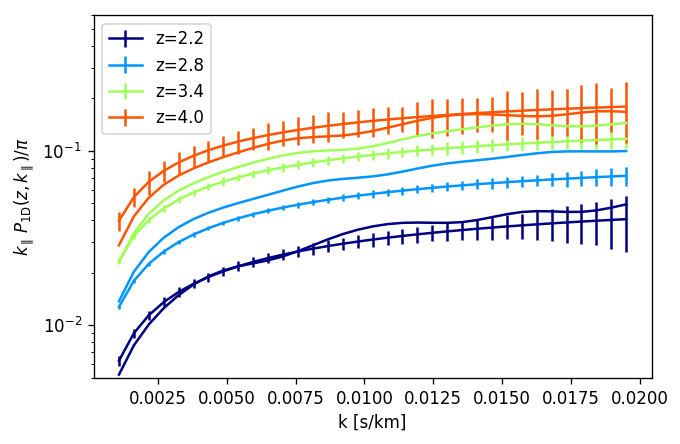

In [21]:
sampler.like.plot_p1d()

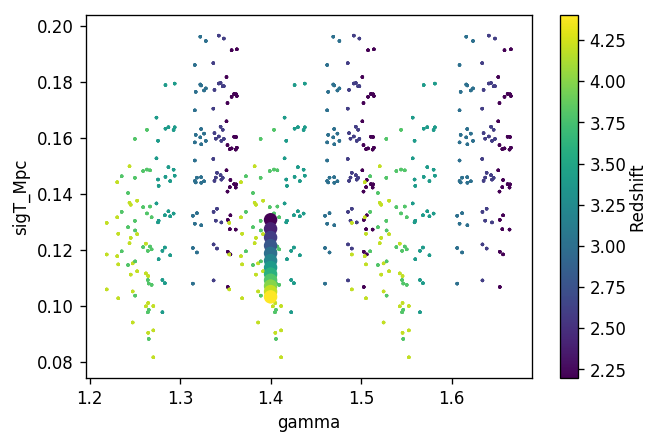

In [22]:
sampler.like.overplot_emulator_calls('gamma','sigT_Mpc')

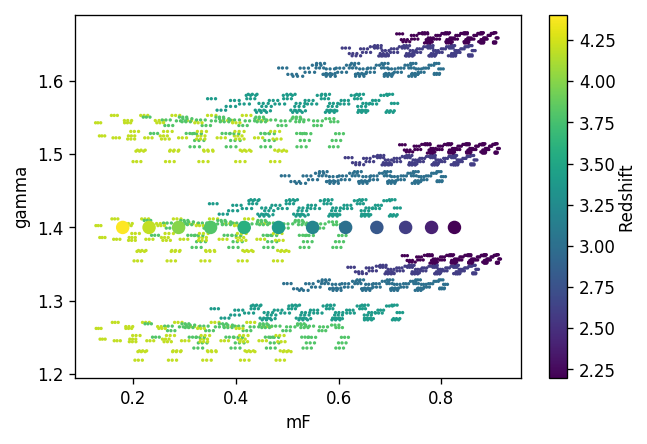

In [23]:
sampler.like.overplot_emulator_calls('mF','gamma')

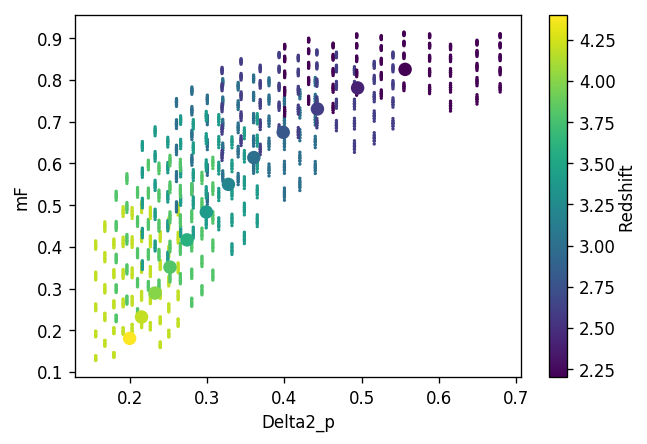

In [24]:
sampler.like.overplot_emulator_calls('Delta2_p','mF')

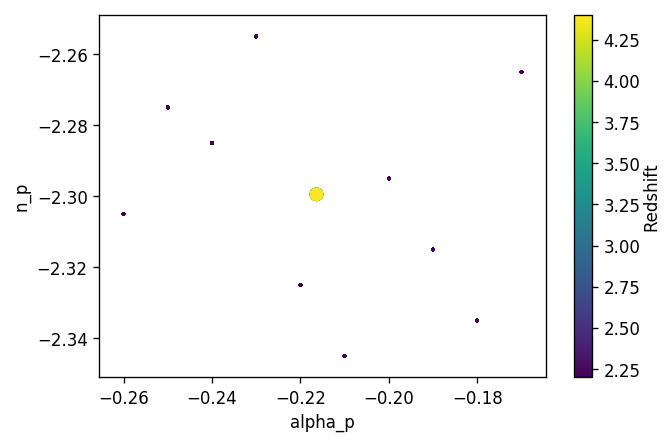

In [25]:
sampler.like.overplot_emulator_calls('alpha_p','n_p')

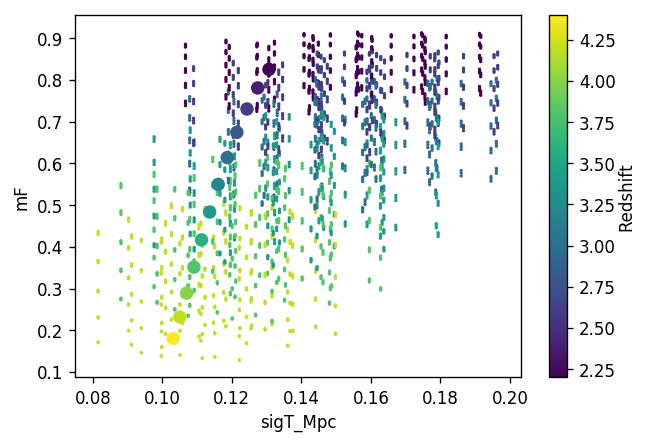

In [26]:
sampler.like.overplot_emulator_calls('sigT_Mpc','mF')

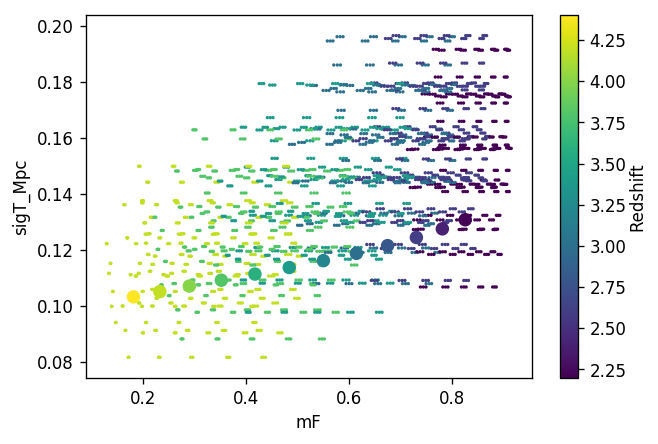

In [27]:
sampler.like.overplot_emulator_calls('mF','sigT_Mpc')

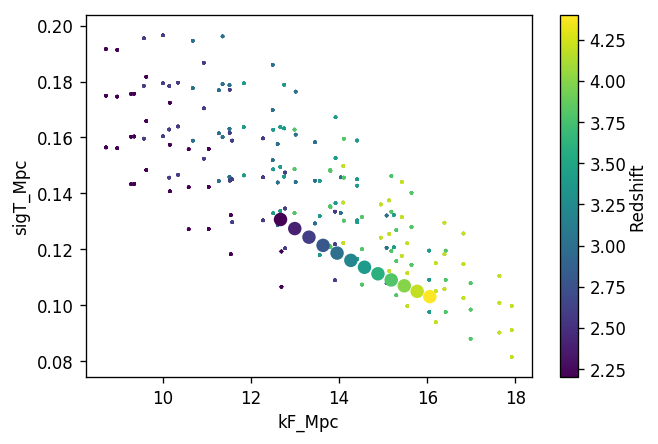

In [28]:
sampler.like.overplot_emulator_calls('kF_Mpc','sigT_Mpc')

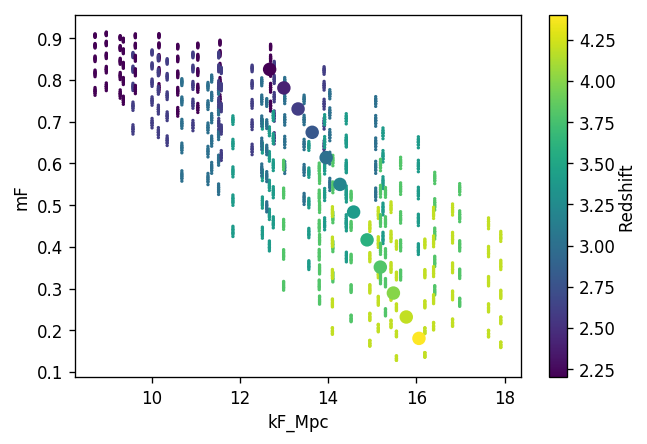

In [29]:
sampler.like.overplot_emulator_calls('kF_Mpc','mF')

### Write chain to file for later use

In [30]:
chain_filename='test'
sampler.write_chain_to_file(chain_filename)

### Read pre-computed chain

In [31]:
new_sampler = emcee_sampler.EmceeSampler(emulator=emu,free_parameters=free_parameters,
                                         read_chain_file=chain_filename,verbose=True)

use default likelihood
Note: redshifts have been re-sorted (earliest first)
will read chain from file test
done setting up sampler


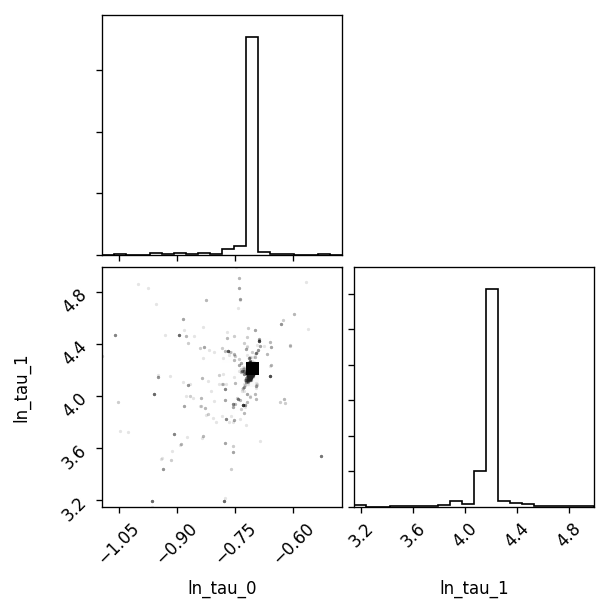

In [32]:
new_sampler.plot_corner(cube=False)

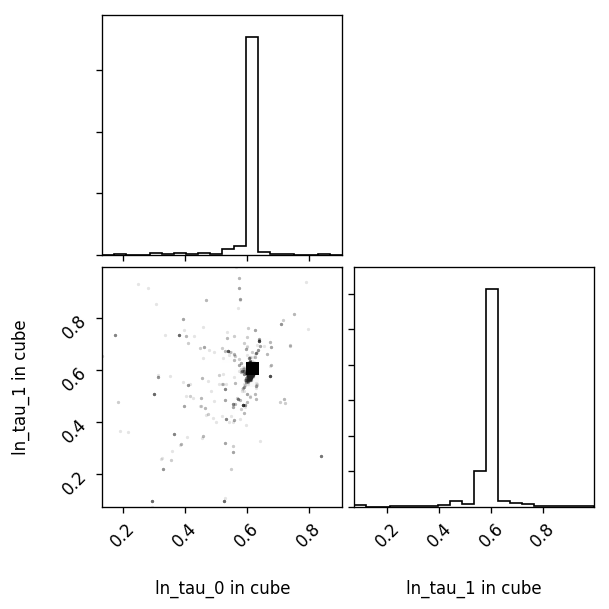

In [33]:
new_sampler.plot_corner(cube=True)

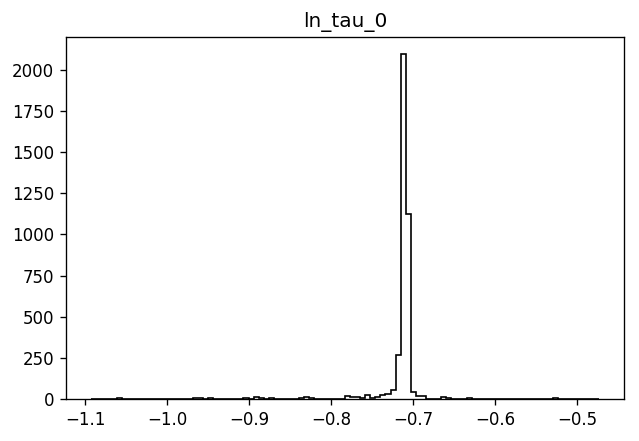

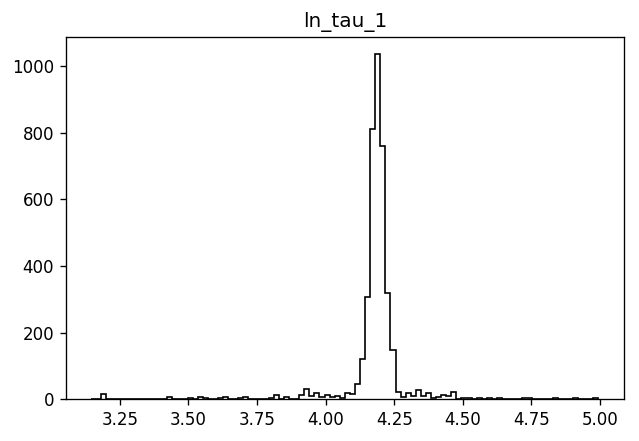

In [34]:
new_sampler.plot_histograms(cube=False)